# Real-world data representation using tensors

### This chapter covers
- Representing real-world data as PyTorch tensors
- Working with a range of data types
- Loading data from a file
- Converting data to tensors
- Shaping tensors so they can be used as inputs for neural network models

Tensors are the building blocks for data in PyTorch. Neural networks take tensors as input and produce tensors as outputs. In fact, all operations within a neural network and during optimization are operations between tensors, and all parameters (for example, weights and biases) in a neural network are tensors.

# Working with images 

An image is represented as a collection of scalars arranged in a regular grid with a
height and a width (in pixels).

### Adding color channels

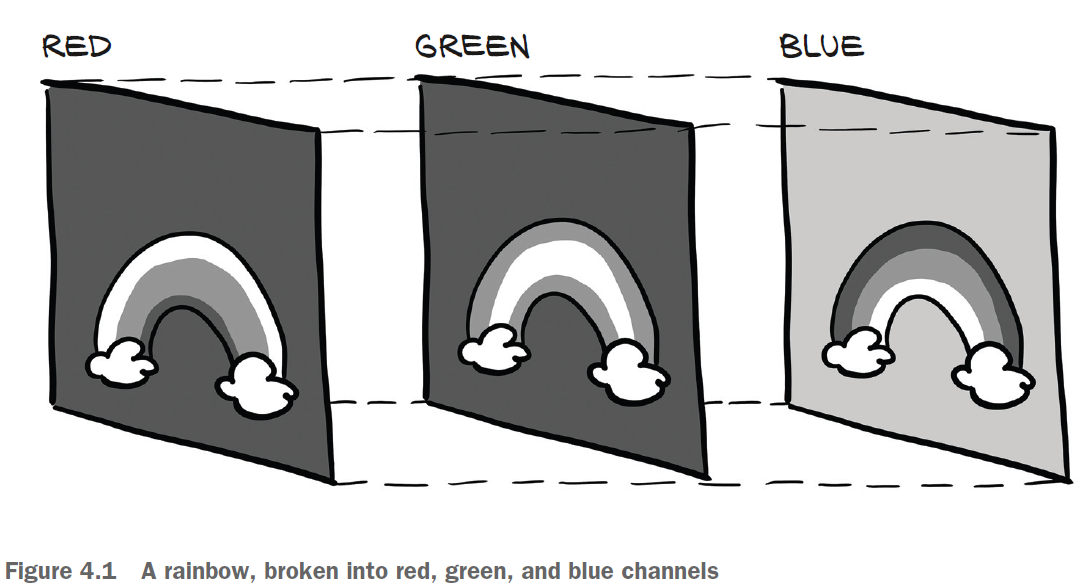
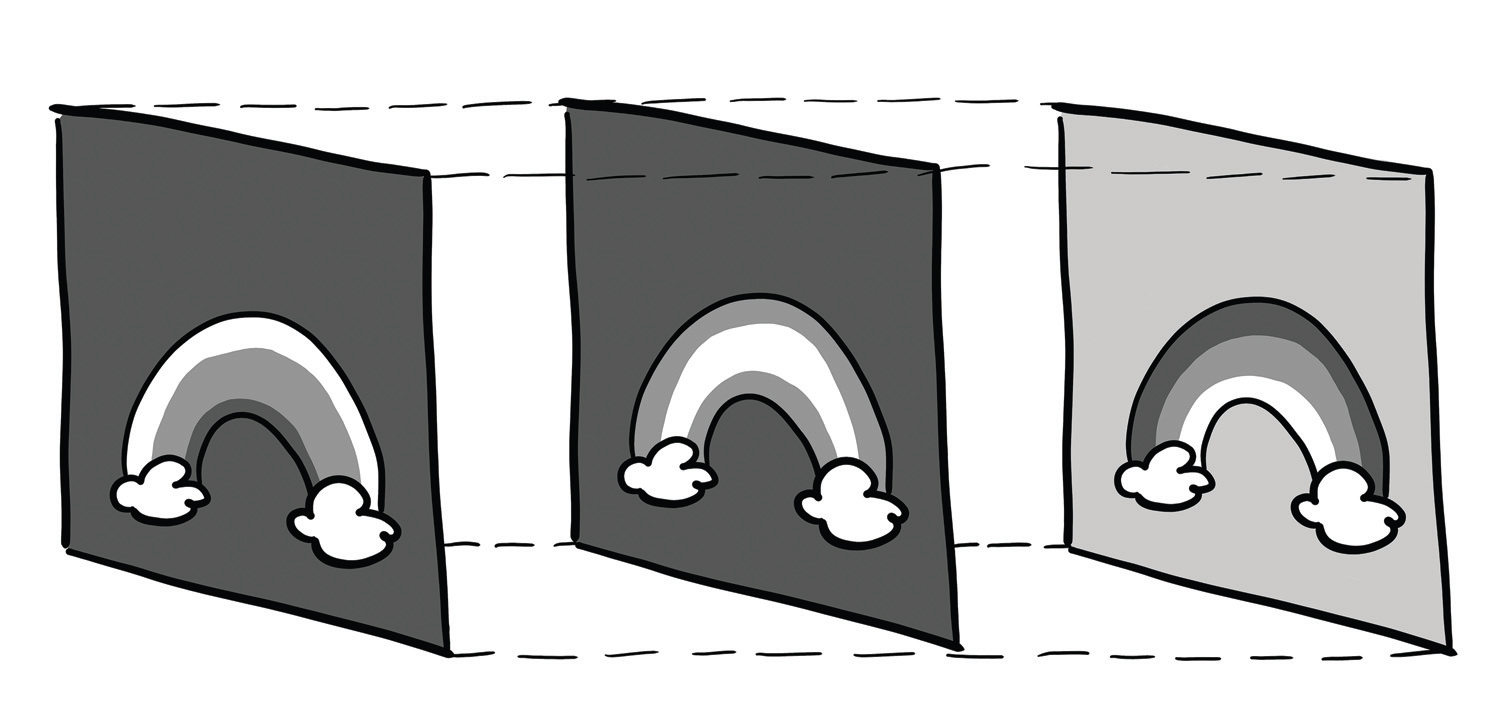

### Loading an image 
Images come in several different file formats, but luckily there are plenty of ways to
load images in Python.

In [1]:
%pip install imageio

Note: you may need to restart the kernel to use updated packages.Collecting imageio



In [3]:
import imageio.v2 as imageio

img_arr = imageio.imread('./sathya-sai-baba.jpg')
img_arr.shape

(457, 370, 3)

- img is a NumPy array-like object with three dimensions: two spatial
dimensions, width and height; and a third dimension corresponding to the red,
green, and blue channels.

### Changing the layout
We can use the tensor’s permute method with the old dimensions for each new dimension
to get to an appropriate layout. Given an input tensor H × W × C as obtained previously,
we get a proper layout by having channel 2 first and then channels 0 and 1:

In [4]:
import torch

In [5]:
img = torch.from_numpy(img_arr)
out = img.permute(2, 0, 1)

- note that this operation does not make a copy of the  tensor data. Instead, out uses the same underlying storage as img and only plays with
the size & stride information at the tensor level. This is convenient because the
operation is very cheap; but just as a heads-up: changing a pixel in img will lead to a
change in out.
- we store the images in a batch along the first dimension to obtain an
N × C × H × W tensor.

As a slightly more efficient alternative to using stack to build up the tensor, we can preallocate
a tensor of appropriate size and fill it with images loaded from a directory, like so:

In [6]:
batch_size = 3
batch = torch.zeros(batch_size, 3, 256, 256, dtype=torch.uint8)

We can now load all PNG images from an input directory and store them in
the tensor:

In [14]:
import os
data_dir = './p1ch4/image-cats'
filenames = [name for name in os.listdir(data_dir)
if os.path.splitext(name)[-1] == '.png']
for i, filename in enumerate(filenames):
    img_arr = imageio.imread(os.path.join(data_dir, filename))
    img_t = torch.from_numpy(img_arr)
    img_t = img_t.permute(2, 0, 1)
    img_t = img_t[:3]  #Here we keep only the first three channels.Sometimes images also have an alpha channel indicating transparency, but our network only wants RGB input.
    batch[i] = img_t

### Normalizing the data

neural networks usually work with floating-point tensors as
their input. Neural networks exhibit the best training performance when the input
data ranges roughly from 0 to 1, or from -1 to 1 (this is an effect of how their building
blocks are defined).


- we’ll want to do is cast a tensor to floating-point and normalize
the values of the pixels. Casting to floating-point is easy, but normalization is trickier,
as it depends on what range of the input we decide should lie between 0 and 1 (or -1
and 1). One possibility is to just divide the values of the pixels by 255 (the maximum
representable number in 8-bit unsigned):

In [15]:
batch = batch.float()
batch /= 255.0

- Another possibility is to compute the mean and standard deviation of the input data
and scale it so that the output has zero mean and unit standard deviation across each
channel:

In [16]:
n_channels = batch.shape[1]
for c in range(n_channels):
    mean = torch.mean(batch[:, c])
    std = torch.std(batch[:, c])
    batch[:, c] = (batch[:, c] - mean) / std

* We can perform several other operations on inputs, such as geometric transformations
like rotations, scaling, and cropping. 

## 3D images: Volumetric data

By stacking individual 2D
slices into a 3D tensor, we can build volumetric data representing the 3D anatomy of a
subject.

### Loading a specialized format

In [26]:
import imageio

dir_path = "./p1ch4//volumetric-dicom/2-LUNG 3.0  B70f-04083"
vol_arr = imageio.volread(dir_path, 'DICOM')
vol_arr.shape

Reading DICOM (examining files): 1/99 files (1.0%18/99 files (18.2%30/99 files (30.3%42/99 files (42.4%54/99 files (54.5%66/99 files (66.7%77/99 files (77.8%88/99 files (88.9%95/99 files (96.0%99/99 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 28/99  (28.366/99  (66.799/99  (100.0%99/99  (100.0%)


(99, 512, 512)

the layout is different from what PyTorch expects, due to
having no channel information. So we’ll have to make room for the channel dimension
using unsqueeze:

In [27]:
vol = torch.from_numpy(vol_arr).float()
vol = torch.unsqueeze(vol, 0)
vol.shape

torch.Size([1, 99, 512, 512])

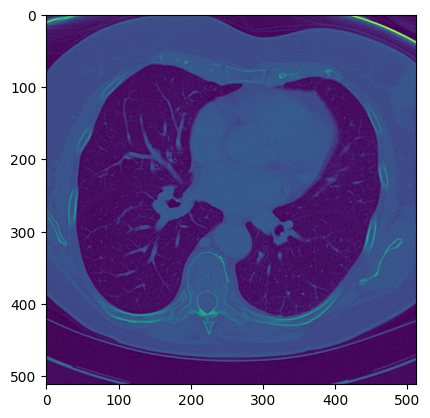

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(vol_arr[50])

## Representing tabular data

 The simplest form of data we’ll encounter on a machine learning job is sitting in a spreadsheet, CSV file, or database. Whatever the medium, it’s a table containing one row per sample (or record), where columns contain one piece of information about our sample.

### Loading a wine data tensor

In [30]:
import csv
import numpy as np

wine_path = "./p1ch4/tabular-wine/winequality-white.csv"
wineq_numpy = np.loadtxt(wine_path, dtype=np.float32, delimiter=";",
skiprows=1)
wineq_numpy

array([[ 7.  ,  0.27,  0.36, ...,  0.45,  8.8 ,  6.  ],
       [ 6.3 ,  0.3 ,  0.34, ...,  0.49,  9.5 ,  6.  ],
       [ 8.1 ,  0.28,  0.4 , ...,  0.44, 10.1 ,  6.  ],
       ...,
       [ 6.5 ,  0.24,  0.19, ...,  0.46,  9.4 ,  6.  ],
       [ 5.5 ,  0.29,  0.3 , ...,  0.38, 12.8 ,  7.  ],
       [ 6.  ,  0.21,  0.38, ...,  0.32, 11.8 ,  6.  ]], dtype=float32)

Here we just prescribe what the type of the 2D array should be (32-bit floating-point),
the delimiter used to separate values in each row, and the fact that the first line should
not be read since it contains the column names

In [31]:
col_list = next(csv.reader(open(wine_path), delimiter=';'))
wineq_numpy.shape, col_list

((4898, 12),
 ['fixed acidity',
  'volatile acidity',
  'citric acid',
  'residual sugar',
  'chlorides',
  'free sulfur dioxide',
  'total sulfur dioxide',
  'density',
  'pH',
  'sulphates',
  'alcohol',
  'quality'])

In [ ]:
#to convert the NumPy array to a PyTorch tensor
wineq = torch.from_numpy(wineq_numpy)
wineq.shape, wineq.dtype

(torch.Size([4898, 12]), torch.float32)

- **Continuous values**: Numeric with meaningful differences and ratios (e.g., weight, distance). Can be **ratio scale** (has a true zero, like weight) or **interval scale** (no true zero, like time of day).

- **Ordinal values**: Ordered categories with no fixed distance between them (e.g., small = 1, medium = 2, large = 3). You can rank them, but don't do math with them.

- **Categorical values**: No order or numeric meaning (e.g., water = 1, soda = 2). Just labels—totally arbitrary. Great for one-hot encoding or embeddings.


### Representing scores

In [33]:
data = wineq[:, :-1] # Selects all rows and all columns except the last
data, data.shape

(tensor([[ 7.0000,  0.2700,  0.3600,  ...,  3.0000,  0.4500,  8.8000],
         [ 6.3000,  0.3000,  0.3400,  ...,  3.3000,  0.4900,  9.5000],
         [ 8.1000,  0.2800,  0.4000,  ...,  3.2600,  0.4400, 10.1000],
         ...,
         [ 6.5000,  0.2400,  0.1900,  ...,  2.9900,  0.4600,  9.4000],
         [ 5.5000,  0.2900,  0.3000,  ...,  3.3400,  0.3800, 12.8000],
         [ 6.0000,  0.2100,  0.3800,  ...,  3.2600,  0.3200, 11.8000]]),
 torch.Size([4898, 11]))

In [34]:
target = wineq[:, -1] # Selects all rows and the last column
target, target.shape

(tensor([6., 6., 6.,  ..., 6., 7., 6.]), torch.Size([4898]))

If we want to transform the target tensor in a tensor of labels, we have two options,
depending on the strategy or what we use the categorical data for. 
One is simply to treat labels as an integer vector of scores:

In [35]:
target = wineq[:, -1].long()
target

tensor([6, 6, 6,  ..., 6, 7, 6])

### One-hot encoding


The other approach is to build a one-hot encoding of the scores: that is, encode each of
the 10 scores in a vector of 10 elements, with all elements set to 0 but one, at a different
index for each score. This way, a score of 1 could be mapped onto the vector
(1,0,0,0,0,0,0,0,0,0), a score of 5 onto (0,0,0,0,1,0,0,0,0,0), and so on.

In [ ]:
target_onehot = torch.zeros(target.shape[0], 10)
# We can achieve one-hot encoding using the scatter_ method, which fills the tensor with values from a source tensor along the indices provided as arguments:
target_onehot.scatter_(1, target.unsqueeze(1), 1.0)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

The arguments for scatter_ are as follows:
- The dimension along which the following two arguments are specified
- A column tensor indicating the indices of the elements to scatter
- A tensor containing the elements to scatter or a single scalar to scatter (1, in
this case)

Since target_onehot has two
dimensions (4,898 × 10), we need to add an extra dummy dimension to target using
unsqueeze:

The call to unsqueeze adds a singleton dimension, from a 1D tensor of 4,898 elements
to a 2D tensor of size (4,898 × 1), without changing its contents—no extra elements
are added; we just decided to use an extra index to access the elements. That is, we
access the first element of target as target[0] and the first element of its
unsqueezed counterpart as target_unsqueezed[0,0].

In [37]:
target_unsqueezed = target.unsqueeze(1)
target_unsqueezed

tensor([[6],
        [6],
        [6],
        ...,
        [6],
        [7],
        [6]])

### When to categorize

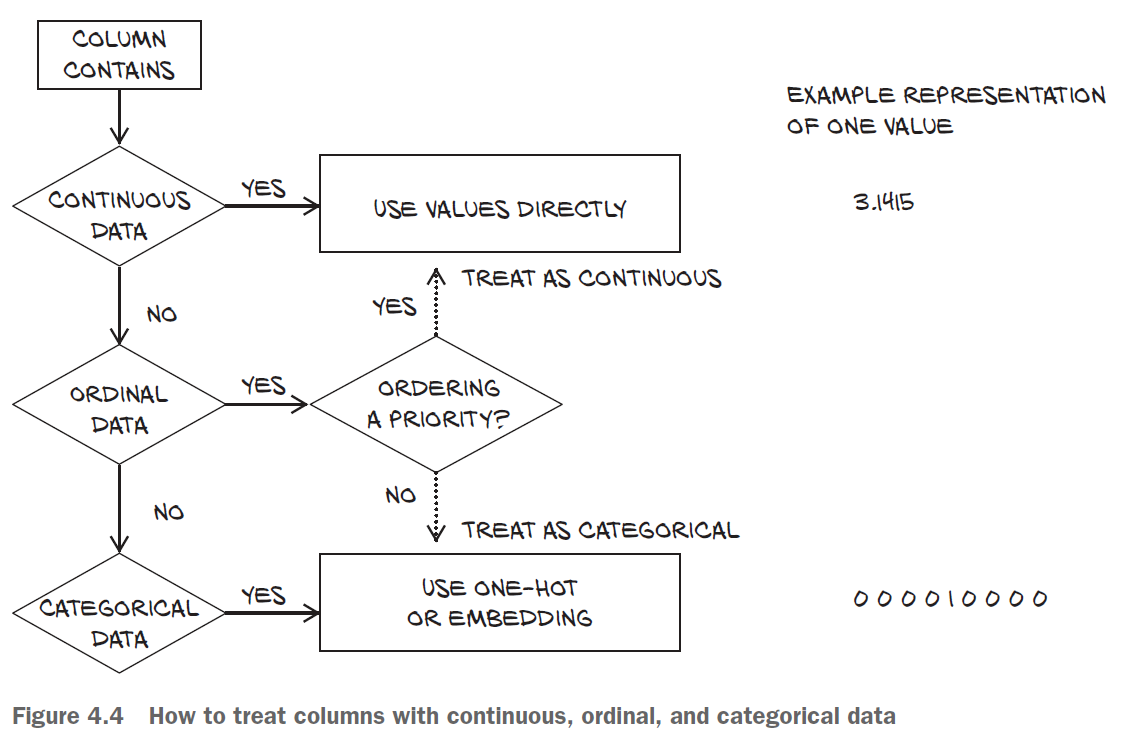

obtain the mean and standard deviations for each column

In [38]:
data_mean = torch.mean(data, dim=0)
data_mean

tensor([6.8548e+00, 2.7824e-01, 3.3419e-01, 6.3914e+00, 4.5772e-02, 3.5308e+01,
        1.3836e+02, 9.9403e-01, 3.1883e+00, 4.8985e-01, 1.0514e+01])

In [39]:
data_var = torch.var(data, dim=0)
data_var

tensor([7.1211e-01, 1.0160e-02, 1.4646e-02, 2.5726e+01, 4.7733e-04, 2.8924e+02,
        1.8061e+03, 8.9455e-06, 2.2801e-02, 1.3025e-02, 1.5144e+00])

In this case, dim=0 indicates that the reduction is performed along dimension 0. At
this point, we can normalize the data by subtracting the mean and dividing by the
standard deviation, which helps with the learning process

In [40]:
data_normalized = (data - data_mean) / torch.sqrt(data_var)
data_normalized

tensor([[ 1.7208e-01, -8.1761e-02,  2.1326e-01,  ..., -1.2468e+00,
         -3.4915e-01, -1.3930e+00],
        [-6.5743e-01,  2.1587e-01,  4.7996e-02,  ...,  7.3995e-01,
          1.3422e-03, -8.2419e-01],
        [ 1.4756e+00,  1.7450e-02,  5.4378e-01,  ...,  4.7505e-01,
         -4.3677e-01, -3.3663e-01],
        ...,
        [-4.2043e-01, -3.7940e-01, -1.1915e+00,  ..., -1.3130e+00,
         -2.6153e-01, -9.0545e-01],
        [-1.6054e+00,  1.1666e-01, -2.8253e-01,  ...,  1.0049e+00,
         -9.6251e-01,  1.8574e+00],
        [-1.0129e+00, -6.7703e-01,  3.7852e-01,  ...,  4.7505e-01,
         -1.4882e+00,  1.0448e+00]])

### Finding thresholds

PyTorch also provides comparison functions,
here torch.le(target, 3), but using operators
seems to be a good standard.

In [41]:
bad_indexes = target <= 3
bad_indexes.shape, bad_indexes.dtype, bad_indexes.sum()

(torch.Size([4898]), torch.bool, tensor(20))

The bad_indexes tensor has the same shape
as target, with values of False or True depending on the outcome of the comparison
between our threshold and each element in the original target tensor:

In [42]:
bad_data = data[bad_indexes]
bad_data.shape

torch.Size([20, 11])

For Boolean NumPy arrays and PyTorch tensors, the & operator does a logical “and” operation.

In [ ]:
bad_data = data[target <= 3]
mid_data = data[(target > 3) & (target < 7)] 
good_data = data[target >= 7]
bad_mean = torch.mean(bad_data, dim=0)
mid_mean = torch.mean(mid_data, dim=0)
good_mean = torch.mean(good_data, dim=0)
for i, args in enumerate(zip(col_list, bad_mean, mid_mean, good_mean)):
    print('{:2} {:20} {:6.2f} {:6.2f} {:6.2f}'.format(i, *args))

 0 fixed acidity          7.60   6.89   6.73
 1 volatile acidity       0.33   0.28   0.27
 2 citric acid            0.34   0.34   0.33
 3 residual sugar         6.39   6.71   5.26
 4 chlorides              0.05   0.05   0.04
 5 free sulfur dioxide   53.33  35.42  34.55
 6 total sulfur dioxide 170.60 141.83 125.25
 7 density                0.99   0.99   0.99
 8 pH                     3.19   3.18   3.22
 9 sulphates              0.47   0.49   0.50
10 alcohol               10.34  10.26  11.42


Let’s get the indexes where the total sulfur dioxide column is below the midpoint we
calculated earlier, like so:

In [44]:
total_sulfur_threshold = 141.83
total_sulfur_data = data[:,6]
predicted_indexes = torch.lt(total_sulfur_data, total_sulfur_threshold)
predicted_indexes.shape, predicted_indexes.dtype, predicted_indexes.sum()

(torch.Size([4898]), torch.bool, tensor(2727))

This means our threshold implies that just over half of all the wines are going to be
high quality. Next, we’ll need to get the indexes of the actually good wines:

In [45]:
actual_indexes = target > 5
actual_indexes.shape, actual_indexes.dtype, actual_indexes.sum()

(torch.Size([4898]), torch.bool, tensor(3258))

We will perform a logical “and” between our
prediction indexes and the actual good indexes (remember that each is just an array
of zeros and ones) and use that intersection of wines-in-agreement to determine how
well we did:

In [46]:
n_matches = torch.sum(actual_indexes & predicted_indexes).item()
n_predicted = torch.sum(predicted_indexes).item()
n_actual = torch.sum(actual_indexes).item()
n_matches, n_matches / n_predicted, n_matches / n_actual

(2018, 0.74000733406674, 0.6193984039287906)

** We got around 2,000 wines right! Since we predicted 2,700 wines, this gives us a 74%
chance that if we predict a wine to be high quality, it actually is. Unfortunately, there
are 3,200 good wines, and we only identified 61% of them.

## Working with time series

### Adding a time dimension

For every hour, the dataset reports the following variables:
- Index of record: instant
- Day of month: day
- Season: season (1: spring, 2: summer, 3: fall, 4: winter)
- Year: yr (0: 2011, 1: 2012)
- Month: mnth (1 to 12)
- Hour: hr (0 to 23)
- Holiday status: holiday
- Day of the week: weekday
- Working day status: workingday
- Weather situation: weathersit (1: clear, 2:mist, 3: light rain/snow, 4: heavy
rain/snow)
- Temperature in °C: temp
- Perceived temperature in °C: atemp
- Humidity: hum
- Wind speed: windspeed
- Number of casual users: casual
- Number of registered users: registered
- Count of rental bikes: cnt

In [ ]:
bikes_numpy = np.loadtxt(
"./p1ch4/bike-sharing-dataset/hour-fixed.csv",
    dtype=np.float32,
    delimiter=",",
    skiprows=1,
    converters={1: lambda x: float(x[8:10])})#Converts date strings to numbers corresponding to the day of the month in column 1
bikes = torch.from_numpy(bikes_numpy)
bikes

tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 3.0000e+00, 1.3000e+01,
         1.6000e+01],
        [2.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 8.0000e+00, 3.2000e+01,
         4.0000e+01],
        [3.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 5.0000e+00, 2.7000e+01,
         3.2000e+01],
        ...,
        [1.7377e+04, 3.1000e+01, 1.0000e+00,  ..., 7.0000e+00, 8.3000e+01,
         9.0000e+01],
        [1.7378e+04, 3.1000e+01, 1.0000e+00,  ..., 1.3000e+01, 4.8000e+01,
         6.1000e+01],
        [1.7379e+04, 3.1000e+01, 1.0000e+00,  ..., 1.2000e+01, 3.7000e+01,
         4.9000e+01]])

### Shaping the data by time period

We might want to break up the two-year dataset into wider observation periods, like
days. This way we’ll have N (for number of samples) collections of C sequences of length
L. In other words, our time series dataset would be a tensor of dimension 3 and shape
N × C × L. The C would remain our 17 channels, while L would be 24: 1 per hour of
the day.

In [48]:
bikes.shape, bikes.stride()

(torch.Size([17520, 17]), (17, 1))

That’s 17,520 hours, 17 columns. Now let’s reshape the data to have 3 axes—day, hour,
and then our 17 columns:

In [49]:
daily_bikes = bikes.view(-1, 24, bikes.shape[1])
daily_bikes.shape, daily_bikes.stride()

(torch.Size([730, 24, 17]), (408, 17, 1))

We see that the rightmost dimension is the number of columns in the original
dataset. Then, in the middle dimension, we have time, split into chunks of 24 sequential
hours. In other words, we now have N sequences of L hours in a day, for C channels.
To get to our desired N × C × L ordering, we need to transpose the tensor:

In [50]:
daily_bikes = daily_bikes.transpose(1, 2)
daily_bikes.shape, daily_bikes.stride()

(torch.Size([730, 17, 24]), (408, 1, 17))

### Ready for training

In order to make it easier to render our data, we’re going to limit ourselves to the
first day for a moment. We initialize a zero-filled matrix with a number of rows equal
to the number of hours in the day and number of columns equal to the number of
weather levels:

In [51]:
first_day = bikes[:24].long()
weather_onehot = torch.zeros(first_day.shape[0], 4)
first_day[:,9]

tensor([1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2])

Then we scatter ones into our matrix according to the corresponding level at each
row. Remember the use of unsqueeze to add a singleton dimension as we did in the
previous sections:

In [ ]:
weather_onehot.scatter_(
    dim=1,
    index=first_day[:,9].unsqueeze(1).long() - 1,#Decreases the values by 1 because weather situation ranges from 1 to 4, while indices are 0-based
    value=1.0)

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]])

Last, we concatenate our matrix to our original dataset using the cat function.
Let’s look at the first of our results:

In [53]:
torch.cat((bikes[:24], weather_onehot), 1)[:1]

tensor([[ 1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  6.0000,
          0.0000,  1.0000,  0.2400,  0.2879,  0.8100,  0.0000,  3.0000, 13.0000,
         16.0000,  1.0000,  0.0000,  0.0000,  0.0000]])

We could have done the same with the reshaped daily_bikes tensor. Remember
that it is shaped (B, C, L), where L = 24. We first create the zero tensor, with the same
B and L, but with the number of additional columns as C:

In [54]:
daily_weather_onehot = torch.zeros(daily_bikes.shape[0], 4,
daily_bikes.shape[2])
daily_weather_onehot.shape

torch.Size([730, 4, 24])

Then we scatter the one-hot encoding into the tensor in the C dimension. Since this
operation is performed in place, only the content of the tensor will change:

In [55]:
daily_weather_onehot.scatter_(
1, daily_bikes[:,9,:].long().unsqueeze(1) - 1, 1.0)
daily_weather_onehot.shape

torch.Size([730, 4, 24])

And we concatenate along the C dimension:

In [56]:
daily_bikes = torch.cat((daily_bikes, daily_weather_onehot), dim=1)

We could just transform the variable so that it runs
from 0.0 to 1.0:

In [57]:
daily_bikes[:, 9, :] = (daily_bikes[:, 9, :] - 1.0) / 3.0

There are multiple possibilities for rescaling variables. We can either map their
range to [0.0, 1.0]

In [58]:
temp = daily_bikes[:, 10, :]
temp_min = torch.min(temp)
temp_max = torch.max(temp)
daily_bikes[:, 10, :] = ((daily_bikes[:, 10, :] - temp_min)
/ (temp_max - temp_min))

or subtract the mean and divide by the standard deviation:

In [60]:
temp = daily_bikes[:, 10, :]
daily_bikes[:, 10, :] = ((daily_bikes[:, 10,:] - torch.mean(temp))
/ torch.std(temp))

In the latter case, our variable will have 0 mean and unitary standard deviation. If our
variable were drawn from a Gaussian distribution, 68% of the samples would sit in the
[-1.0, 1.0] interval.

## Representing text

Deep learning has taken the field of natural language processing (NLP) by storm, particularly
using models that repeatedly consume a combination of new input and previous
model output. These models are called recurrent neural networks (RNNs), and they
have been applied with great success to text categorization, text generation, and automated
translation systems.

Our goal in this section is to turn text into something a neural network can process:
a tensor of numbers, just like our previous cases. If we can do that and later
choose the right architecture for our text-processing job, we’ll be in the position of
doing NLP with PyTorch.

### Converting text to numbers

There are two particularly intuitive levels at which networks operate on text: at the
character level, by processing one character at a time, and at the word level, where
individual words are the finest-grained entities to be seen by the network. The technique
with which we encode text information into tensor form is the same whether we
operate at the character level or the word level. And it’s not magic, either. We stumbled
upon it earlier: one-hot encoding.


In [61]:
with open('./p1ch4/jane-austen/1342-0.txt', encoding='utf8') as f:
    text = f.read()

### One-hot-encoding characters

One-Hot Encoding is a method of representing characters or words by a vector where only one element is set to one and all others are zero, based on their position in the vocabulary. This results in a sparse, semantically independent vector with a high dimension.

- We first split our text into a list of lines and pick an arbitrary line to focus on:

In [62]:
lines = text.split('\n')
line = lines[200]
line

'“Impossible, Mr. Bennet, impossible, when I am not acquainted with him'

- Let’s create a tensor that can hold the total number of one-hot-encoded characters for
the whole line:

In [ ]:
letter_t = torch.zeros(len(line), 128) #128 hardcoded due to the limits of ASCII
letter_t.shape

torch.Size([70, 128])

- The index where the one has to be set corresponds to the index of the character
in the encoding:

In [64]:
for i, letter in enumerate(line.lower().strip()):
    letter_index = ord(letter) if ord(letter) < 128 else 0
    letter_t[i][letter_index] = 1

### One-hot encoding whole words

- We’ll define clean_words, which takes text and returns it in lowercase and
stripped of punctuation.

In [65]:
def clean_words(input_str):
    punctuation = '.,;:"!?”“_-'
    word_list = input_str.lower().replace('\n',' ').split()
    word_list = [word.strip(punctuation) for word in word_list]
    return word_list
words_in_line = clean_words(line)
line, words_in_line

('“Impossible, Mr. Bennet, impossible, when I am not acquainted with him',
 ['impossible',
  'mr',
  'bennet',
  'impossible',
  'when',
  'i',
  'am',
  'not',
  'acquainted',
  'with',
  'him'])

- Next, let’s build a mapping of words to indexes in our encoding:

In [66]:
word_list = sorted(set(clean_words(text)))
word2index_dict = {word: i for (i, word) in enumerate(word_list)}
len(word2index_dict), word2index_dict['impossible']

(7261, 3394)

- We create an
empty vector and assign the one-hot-encoded values of the word in the sentence:

In [ ]:
word_t = torch.zeros(len(words_in_line), len(word2index_dict))
for i, word in enumerate(words_in_line):
    word_index = word2index_dict[word]
    word_t[i][word_index] = 1
    print('{:2} {:4} {}'.format(i, word_index, word))
print(word_t.shape)
#At this point, tensor represents one sentence of length 11 in an encoding space of size 7,261, the number of words in our dictionary.

 0 3394 impossible
 1 4305 mr
 2  813 bennet
 3 3394 impossible
 4 7078 when
 5 3315 i
 6  415 am
 7 4436 not
 8  239 acquainted
 9 7148 with
10 3215 him
torch.Size([11, 7261])
